# 04. Ensemble Models

## Muc tieu
- Train cac ensemble model co ban: Random Forest, XGBoost, LightGBM
- Train cac SVM toi uu (Bagging SVM, Nystroem + SGD)
- Thiet ke cac ensemble methods: Voting, Stacking, Blending
- So sanh voi single models
- Thuc hien Ablation Study
- Chon model tot nhat cho bai toan

In [1]:
# Import thu vien
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Sklearn
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import (
    VotingClassifier,
    StackingClassifier,
    RandomForestClassifier,
    BaggingClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve
)
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Optuna cho hyperparameter tuning
import optuna
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Cau hinh
RANDOM_STATE = 42
N_FOLDS = 5
N_OPTUNA_TRIALS = 50

plt.style.use('seaborn-v0_8-whitegrid')

/Users/kotori/miniconda/envs/py311_dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load du lieu va models da train

In [2]:
# Load du lieu
X_train = np.load('data/X_train.npy')
X_val = np.load('data/X_val.npy')
X_test = np.load('data/X_test.npy')
y_train = np.load('data/y_train.npy')
y_val = np.load('data/y_val.npy')
y_test = np.load('data/y_test.npy')
feature_names = np.load('data/feature_names.npy', allow_pickle=True)

# Ket hop train va val
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

print("Da load du lieu:")
print(f"  Train+Val: {X_train_full.shape}")
print(f"  Test: {X_test.shape}")

Da load du lieu:
  Train+Val: (58342, 14)
  Test: (10296, 14)


In [3]:
# Load ket qua single models de so sanh
try:
    single_results = pd.read_csv('outputs/single_models_results.csv', index_col=0)
    print("\nKet qua Single Models:")
    print(single_results[['accuracy', 'recall', 'f1', 'roc_auc']].to_string())
except:
    print("Chua co ket qua single models. Hay chay file 03 truoc!")


Ket qua Single Models:
                    accuracy  recall      f1  roc_auc
SGD                   0.7274  0.7081  0.7199      NaN
DecisionTree          0.7253  0.7130  0.7198   0.7811
MLP                   0.7288  0.6985  0.7182   0.7979
KNN                   0.7201  0.6841  0.7075   0.7814
LogisticRegression    0.7262  0.6623  0.7053   0.7908
NaiveBayes            0.7205  0.6123  0.6843   0.7851


## 2. Dinh nghia ham danh gia

In [4]:
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

def evaluate_model(model, X, y, model_name="Model"):
    """
    Danh gia model va tra ve dictionary cac metrics
    """
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else None
    
    metrics = {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1': f1_score(y, y_pred),
        'roc_auc': roc_auc_score(y, y_proba) if y_proba is not None else None
    }
    
    return metrics, y_pred, y_proba


def print_metrics(metrics, model_name):
    """
    In ket qua metrics
    """
    print(f"\n{'='*50}")
    print(f"KET QUA: {model_name}")
    print(f"{'='*50}")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}  <- Quan trong!")
    print(f"  F1-Score:  {metrics['f1']:.4f}  <- Quan trong!")
    if metrics['roc_auc']:
        print(f"  ROC-AUC:   {metrics['roc_auc']:.4f}")

## 3. Pre-built Ensemble Models (Random Forest, XGBoost, LightGBM)

In [5]:
# Dictionary luu ket qua
ensemble_results = {}
trained_ensembles = {}
best_params = {}

### 3.1 Random Forest

In [6]:
print("\n" + "="*60)
print("TRAINING: Random Forest")
print("="*60)

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'random_state': RANDOM_STATE,
        'n_jobs': -1
    }
    model = RandomForestClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    return scores.mean()

sampler = TPESampler(seed=RANDOM_STATE)
study_rf = optuna.create_study(direction='maximize', sampler=sampler)

start_time = time.time()
study_rf.optimize(objective_rf, n_trials=N_OPTUNA_TRIALS, show_progress_bar=True)
tune_time = time.time() - start_time

print(f"\nTuning time: {tune_time:.2f}s")
print(f"Best F1 (CV): {study_rf.best_value:.4f}")
print(f"Best params: {study_rf.best_params}")

best_params['RandomForest'] = study_rf.best_params
model_rf = RandomForestClassifier(**study_rf.best_params, random_state=RANDOM_STATE, n_jobs=-1)

start_time = time.time()
model_rf.fit(X_train_full, y_train_full)
train_time = time.time() - start_time

metrics_rf, y_pred_rf, y_proba_rf = evaluate_model(model_rf, X_test, y_test)
metrics_rf['train_time'] = train_time
metrics_rf['tune_time'] = tune_time

ensemble_results['RandomForest'] = metrics_rf
trained_ensembles['RandomForest'] = model_rf

print_metrics(metrics_rf, 'Random Forest')


TRAINING: Random Forest


Best trial: 47. Best value: 0.719153: 100%|██████████| 50/50 [03:36<00:00,  4.33s/it]



Tuning time: 216.57s
Best F1 (CV): 0.7192
Best params: {'n_estimators': 241, 'max_depth': 19, 'min_samples_split': 13, 'min_samples_leaf': 5}

KET QUA: Random Forest
  Accuracy:  0.7291
  Precision: 0.7483
  Recall:    0.6818  <- Quan trong!
  F1-Score:  0.7135  <- Quan trong!
  ROC-AUC:   0.7971


### 3.2 XGBoost

In [7]:
print("\n" + "="*60)
print("TRAINING: XGBoost")
print("="*60)

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': RANDOM_STATE,
        'eval_metric': 'logloss'
    }
    model = XGBClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    return scores.mean()

sampler = TPESampler(seed=RANDOM_STATE)
study_xgb = optuna.create_study(direction='maximize', sampler=sampler)

start_time = time.time()
study_xgb.optimize(objective_xgb, n_trials=N_OPTUNA_TRIALS, show_progress_bar=True)
tune_time = time.time() - start_time

print(f"\nTuning time: {tune_time:.2f}s")
print(f"Best F1 (CV): {study_xgb.best_value:.4f}")
print(f"Best params: {study_xgb.best_params}")

best_params['XGBoost'] = study_xgb.best_params
model_xgb = XGBClassifier(**study_xgb.best_params, random_state=RANDOM_STATE, eval_metric='logloss')

start_time = time.time()
model_xgb.fit(X_train_full, y_train_full)
train_time = time.time() - start_time

metrics_xgb, y_pred_xgb, y_proba_xgb = evaluate_model(model_xgb, X_test, y_test)
metrics_xgb['train_time'] = train_time
metrics_xgb['tune_time'] = tune_time

ensemble_results['XGBoost'] = metrics_xgb
trained_ensembles['XGBoost'] = model_xgb

print_metrics(metrics_xgb, 'XGBoost')


TRAINING: XGBoost


Best trial: 37. Best value: 0.721232: 100%|██████████| 50/50 [01:40<00:00,  2.01s/it]



Tuning time: 100.52s
Best F1 (CV): 0.7212
Best params: {'n_estimators': 256, 'max_depth': 6, 'learning_rate': 0.039068296207675, 'subsample': 0.6189363877084141, 'colsample_bytree': 0.7421548856945066, 'reg_alpha': 9.650554673574444, 'reg_lambda': 0.0010415523414613317}

KET QUA: XGBoost
  Accuracy:  0.7341
  Precision: 0.7529
  Recall:    0.6885  <- Quan trong!
  F1-Score:  0.7192  <- Quan trong!
  ROC-AUC:   0.7998


### 3.3 LightGBM

In [8]:
print("\n" + "="*60)
print("TRAINING: LightGBM")
print("="*60)

def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': RANDOM_STATE,
        'verbose': -1
    }
    model = LGBMClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    return scores.mean()

sampler = TPESampler(seed=RANDOM_STATE)
study_lgbm = optuna.create_study(direction='maximize', sampler=sampler)

start_time = time.time()
study_lgbm.optimize(objective_lgbm, n_trials=N_OPTUNA_TRIALS, show_progress_bar=True)
tune_time = time.time() - start_time

print(f"\nTuning time: {tune_time:.2f}s")
print(f"Best F1 (CV): {study_lgbm.best_value:.4f}")
print(f"Best params: {study_lgbm.best_params}")

best_params['LightGBM'] = study_lgbm.best_params
model_lgbm = LGBMClassifier(**study_lgbm.best_params, random_state=RANDOM_STATE, verbose=-1)

start_time = time.time()
model_lgbm.fit(X_train_full, y_train_full)
train_time = time.time() - start_time

metrics_lgbm, y_pred_lgbm, y_proba_lgbm = evaluate_model(model_lgbm, X_test, y_test)
metrics_lgbm['train_time'] = train_time
metrics_lgbm['tune_time'] = tune_time

ensemble_results['LightGBM'] = metrics_lgbm
trained_ensembles['LightGBM'] = model_lgbm

print_metrics(metrics_lgbm, 'LightGBM')


TRAINING: LightGBM


Best trial: 41. Best value: 0.72242: 100%|██████████| 50/50 [04:30<00:00,  5.42s/it] 



Tuning time: 270.99s
Best F1 (CV): 0.7224
Best params: {'n_estimators': 288, 'max_depth': 7, 'learning_rate': 0.037686060570171265, 'num_leaves': 20, 'subsample': 0.6222188637129895, 'colsample_bytree': 0.999117921936498, 'reg_alpha': 4.322737888137572, 'reg_lambda': 0.012261710760495346}

KET QUA: LightGBM
  Accuracy:  0.7325
  Precision: 0.7514
  Recall:    0.6865  <- Quan trong!
  F1-Score:  0.7175  <- Quan trong!
  ROC-AUC:   0.7996


### 3.4 Bagging SVM

Thay vi train 1 con SVM khong lo tren toan bo du lieu (cham vi O(n^2) hoac O(n^3)), 
ta chia du lieu thanh nhieu phan nho va train nhieu con SVM song song.

**Uu diem:**
- Train nhanh hon nhieu (10 x 5800^2 << 58000^2)
- Giam phuong sai (variance), chong overfitting
- Dung chat Ensemble!

In [9]:
print("\n" + "="*60)
print("TRAINING: Bagging SVM")
print("10 SVMs, moi cai train tren 10% du lieu")
print("Nhanh hon SVM truyen thong rat nhieu!")
print("="*60)

def objective_bagging_svm(trial):
    base_svm = SVC(
        C=trial.suggest_float('C', 0.1, 10.0, log=True),
        kernel=trial.suggest_categorical('kernel', ['rbf', 'poly']),
        gamma=trial.suggest_categorical('gamma', ['scale', 'auto']),
        probability=True,
        random_state=RANDOM_STATE
    )
    
    model = BaggingClassifier(
        estimator=base_svm,
        n_estimators=trial.suggest_int('n_estimators', 5, 15),
        max_samples=trial.suggest_float('max_samples', 0.1, 0.3),
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    return scores.mean()

sampler = TPESampler(seed=RANDOM_STATE)
study_bagging = optuna.create_study(direction='maximize', sampler=sampler)

start_time = time.time()
study_bagging.optimize(objective_bagging_svm, n_trials=30, show_progress_bar=True)  # It trials hon
tune_time = time.time() - start_time

print(f"\nTuning time: {tune_time:.2f}s")
print(f"Best F1 (CV): {study_bagging.best_value:.4f}")
print(f"Best params: {study_bagging.best_params}")

best_params['BaggingSVM'] = study_bagging.best_params

# Xay dung model voi best params
base_svm = SVC(
    C=study_bagging.best_params['C'],
    kernel=study_bagging.best_params['kernel'],
    gamma=study_bagging.best_params['gamma'],
    probability=True,
    random_state=RANDOM_STATE
)

model_bagging_svm = BaggingClassifier(
    estimator=base_svm,
    n_estimators=study_bagging.best_params['n_estimators'],
    max_samples=study_bagging.best_params['max_samples'],
    random_state=RANDOM_STATE,
    n_jobs=-1
)

start_time = time.time()
model_bagging_svm.fit(X_train_full, y_train_full)
train_time = time.time() - start_time

metrics_bagging, y_pred_bagging, y_proba_bagging = evaluate_model(model_bagging_svm, X_test, y_test)
metrics_bagging['train_time'] = train_time
metrics_bagging['tune_time'] = tune_time

ensemble_results['BaggingSVM'] = metrics_bagging
trained_ensembles['BaggingSVM'] = model_bagging_svm

print_metrics(metrics_bagging, 'Bagging SVM')


TRAINING: Bagging SVM
10 SVMs, moi cai train tren 10% du lieu
Nhanh hon SVM truyen thong rat nhieu!


Best trial: 13. Best value: 0.720324: 100%|██████████| 30/30 [44:35<00:00, 89.19s/it] 



Tuning time: 2675.61s
Best F1 (CV): 0.7203
Best params: {'C': 2.4712903632252723, 'kernel': 'rbf', 'gamma': 'scale', 'n_estimators': 12, 'max_samples': 0.1653074057566815}

KET QUA: Bagging SVM
  Accuracy:  0.7330
  Precision: 0.7511
  Recall:    0.6885  <- Quan trong!
  F1-Score:  0.7184  <- Quan trong!
  ROC-AUC:   0.7924


### 3.5 Nystroem + SGD (Kernel Approximation SVM)

Muon co suc manh cua RBF kernel ma van nhanh nhu Linear SVM?

**Cach lam:**
1. Dung Nystroem de xap xi kernel RBF (chuyen du lieu sang khong gian moi)
2. Dung SGDClassifier (Linear SVM) tren khong gian moi

**Ket qua:** Phi tuyen nhu RBF kernel, nhanh nhu Linear!

In [10]:
print("\n" + "="*60)
print("TRAINING: Nystroem + SGD (Kernel Approximation)")
print("Xap xi RBF kernel + Linear SVM")
print("="*60)

def objective_nystroem(trial):
    nystroem = Nystroem(
        kernel='rbf',
        n_components=trial.suggest_int('n_components', 100, 500),
        gamma=trial.suggest_float('gamma', 1e-4, 1.0, log=True),
        random_state=RANDOM_STATE
    )
    
    sgd = SGDClassifier(
        loss='hinge',
        alpha=trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
        max_iter=1000,
        random_state=RANDOM_STATE
    )
    
    model = Pipeline([
        ('nystroem', nystroem),
        ('sgd', sgd)
    ])
    
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    return scores.mean()

sampler = TPESampler(seed=RANDOM_STATE)
study_nystroem = optuna.create_study(direction='maximize', sampler=sampler)

start_time = time.time()
study_nystroem.optimize(objective_nystroem, n_trials=30, show_progress_bar=True)
tune_time = time.time() - start_time

print(f"\nTuning time: {tune_time:.2f}s")
print(f"Best F1 (CV): {study_nystroem.best_value:.4f}")
print(f"Best params: {study_nystroem.best_params}")

best_params['NystroemSGD'] = study_nystroem.best_params

model_nystroem = Pipeline([
    ('nystroem', Nystroem(
        kernel='rbf',
        n_components=study_nystroem.best_params['n_components'],
        gamma=study_nystroem.best_params['gamma'],
        random_state=RANDOM_STATE
    )),
    ('sgd', SGDClassifier(
        loss='hinge',
        alpha=study_nystroem.best_params['alpha'],
        max_iter=1000,
        random_state=RANDOM_STATE
    ))
])

start_time = time.time()
model_nystroem.fit(X_train_full, y_train_full)
train_time = time.time() - start_time

# Nystroem + SGD khong co predict_proba
y_pred_nystroem = model_nystroem.predict(X_test)
metrics_nystroem = {
    'accuracy': accuracy_score(y_test, y_pred_nystroem),
    'precision': precision_score(y_test, y_pred_nystroem),
    'recall': recall_score(y_test, y_pred_nystroem),
    'f1': f1_score(y_test, y_pred_nystroem),
    'roc_auc': None,
    'train_time': train_time,
    'tune_time': tune_time
}

ensemble_results['NystroemSGD'] = metrics_nystroem
trained_ensembles['NystroemSGD'] = model_nystroem

print_metrics(metrics_nystroem, 'Nystroem + SGD')


TRAINING: Nystroem + SGD (Kernel Approximation)
Xap xi RBF kernel + Linear SVM


Best trial: 8. Best value: 0.716648: 100%|██████████| 30/30 [01:25<00:00,  2.85s/it]



Tuning time: 85.39s
Best F1 (CV): 0.7166
Best params: {'n_components': 282, 'gamma': 0.13826232179369857, 'alpha': 6.290644294586152e-05}

KET QUA: Nystroem + SGD
  Accuracy:  0.7281
  Precision: 0.7363
  Recall:    0.7020  <- Quan trong!
  F1-Score:  0.7187  <- Quan trong!


## 4. True Ensemble (Single Models)

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
print("\n" + "="*60)
print("TRUE ENSEMBLE: Combining Single Models")
print("="*60)

# 1. Define Best Params for Single Models (from 03_SingleModels.ipynb)
# Luu y: Cac tham so nay lay tu ket qua chay file 03
single_params = {
    'LR': {'C': 0.155, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 1000, 'random_state': RANDOM_STATE},
    'KNN': {'n_neighbors': 29, 'weights': 'distance', 'metric': 'euclidean', 'n_jobs': -1},
    'NB': {'var_smoothing': 1.767e-10},
    'DT': {'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 3, 'criterion': 'entropy', 'random_state': RANDOM_STATE},
    'MLP': {'hidden_layer_sizes': (41,), 'activation': 'relu', 'alpha': 0.00055, 'learning_rate_init': 0.0039, 'max_iter': 500, 'random_state': RANDOM_STATE}
}

# 2. Instantiate Single Models
single_estimators = [
    ('lr', LogisticRegression(**single_params['LR'])),
    ('knn', KNeighborsClassifier(**single_params['KNN'])),
    ('nb', GaussianNB(**single_params['NB'])),
    ('dt', DecisionTreeClassifier(**single_params['DT'])),
    ('mlp', MLPClassifier(**single_params['MLP']))
]

print("Single Models initialized for Ensemble:")
for name, model in single_estimators:
    print(f"  - {name}: {model.__class__.__name__}")


TRUE ENSEMBLE: Combining Single Models
Single Models initialized for Ensemble:
  - lr: LogisticRegression
  - knn: KNeighborsClassifier
  - nb: GaussianNB
  - dt: DecisionTreeClassifier
  - mlp: MLPClassifier


### 4.1 Single Models Voting (Soft)

In [14]:
print("\n" + "="*60)
print("TRUE ENSEMBLE: Soft Voting (Single Models)")
print("="*60)

model_voting_single = VotingClassifier(
    estimators=single_estimators,
    voting='soft',
    n_jobs=-1
)

start_time = time.time()
model_voting_single.fit(X_train_full, y_train_full)
train_time = time.time() - start_time

metrics_voting_single, _, _ = evaluate_model(model_voting_single, X_test, y_test)
metrics_voting_single['train_time'] = train_time

ensemble_results['Voting_Single'] = metrics_voting_single
trained_ensembles['Voting_Single'] = model_voting_single

print_metrics(metrics_voting_single, 'True Ensemble: Soft Voting')


TRUE ENSEMBLE: Soft Voting (Single Models)

KET QUA: True Ensemble: Soft Voting
  Accuracy:  0.7273
  Precision: 0.7669
  Recall:    0.6447  <- Quan trong!
  F1-Score:  0.7005  <- Quan trong!
  ROC-AUC:   0.7974


### 4.2 Single Models Stacking

In [15]:
print("\n" + "="*60)
print("TRUE ENSEMBLE: Stacking (Single Models)")
print("="*60)

meta_learner_single = LogisticRegression(random_state=RANDOM_STATE)

model_stacking_single = StackingClassifier(
    estimators=single_estimators,
    final_estimator=meta_learner_single,
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1
)

start_time = time.time()
model_stacking_single.fit(X_train_full, y_train_full)
train_time = time.time() - start_time

metrics_stacking_single, _, _ = evaluate_model(model_stacking_single, X_test, y_test)
metrics_stacking_single['train_time'] = train_time

ensemble_results['Stacking_Single'] = metrics_stacking_single
trained_ensembles['Stacking_Single'] = model_stacking_single

print_metrics(metrics_stacking_single, 'True Ensemble: Stacking')


TRUE ENSEMBLE: Stacking (Single Models)

KET QUA: True Ensemble: Stacking
  Accuracy:  0.7316
  Precision: 0.7404
  Recall:    0.7048  <- Quan trong!
  F1-Score:  0.7221  <- Quan trong!
  ROC-AUC:   0.7982


## 5. Ensemble of Pre-built Models (RF, XGB, LGBM)

### 4.1 Hard Voting

In [16]:
print("\n" + "="*60)
print("ENSEMBLE: Hard Voting (Da so phieu)")
print("="*60)

# Su dung cac base models da train
estimators_voting = [
    ('rf', RandomForestClassifier(**best_params['RandomForest'], random_state=RANDOM_STATE, n_jobs=-1)),
    ('xgb', XGBClassifier(**best_params['XGBoost'], random_state=RANDOM_STATE, eval_metric='logloss')),
    ('lgbm', LGBMClassifier(**best_params['LightGBM'], random_state=RANDOM_STATE, verbose=-1)),
]

model_hard_voting = VotingClassifier(
    estimators=estimators_voting,
    voting='hard'
)

start_time = time.time()
model_hard_voting.fit(X_train_full, y_train_full)
train_time = time.time() - start_time

y_pred_hard = model_hard_voting.predict(X_test)
metrics_hard = {
    'accuracy': accuracy_score(y_test, y_pred_hard),
    'precision': precision_score(y_test, y_pred_hard),
    'recall': recall_score(y_test, y_pred_hard),
    'f1': f1_score(y_test, y_pred_hard),
    'roc_auc': None,
    'train_time': train_time
}

ensemble_results['HardVoting'] = metrics_hard
trained_ensembles['HardVoting'] = model_hard_voting

print_metrics(metrics_hard, 'Hard Voting')
print(f"\nBase models: RF, XGBoost, LightGBM")


ENSEMBLE: Hard Voting (Da so phieu)

KET QUA: Hard Voting
  Accuracy:  0.7332
  Precision: 0.7525
  Recall:    0.6865  <- Quan trong!
  F1-Score:  0.7180  <- Quan trong!

Base models: RF, XGBoost, LightGBM


### 4.2 Soft Voting

In [17]:
print("\n" + "="*60)
print("ENSEMBLE: Soft Voting (Trung binh xac suat)")
print("="*60)

estimators_soft = [
    ('rf', RandomForestClassifier(**best_params['RandomForest'], random_state=RANDOM_STATE, n_jobs=-1)),
    ('xgb', XGBClassifier(**best_params['XGBoost'], random_state=RANDOM_STATE, eval_metric='logloss')),
    ('lgbm', LGBMClassifier(**best_params['LightGBM'], random_state=RANDOM_STATE, verbose=-1)),
]

model_soft_voting = VotingClassifier(
    estimators=estimators_soft,
    voting='soft'
)

start_time = time.time()
model_soft_voting.fit(X_train_full, y_train_full)
train_time = time.time() - start_time

metrics_soft, y_pred_soft, y_proba_soft = evaluate_model(model_soft_voting, X_test, y_test)
metrics_soft['train_time'] = train_time

ensemble_results['SoftVoting'] = metrics_soft
trained_ensembles['SoftVoting'] = model_soft_voting

print_metrics(metrics_soft, 'Soft Voting')
print(f"\nBase models: RF, XGBoost, LightGBM")


ENSEMBLE: Soft Voting (Trung binh xac suat)

KET QUA: Soft Voting
  Accuracy:  0.7321
  Precision: 0.7513
  Recall:    0.6855  <- Quan trong!
  F1-Score:  0.7169  <- Quan trong!
  ROC-AUC:   0.7997

Base models: RF, XGBoost, LightGBM


### 4.3 Stacking

In [18]:
print("\n" + "="*60)
print("ENSEMBLE: Stacking (Meta-learner)")
print("="*60)

base_learners = [
    ('rf', RandomForestClassifier(**best_params['RandomForest'], random_state=RANDOM_STATE, n_jobs=-1)),
    ('xgb', XGBClassifier(**best_params['XGBoost'], random_state=RANDOM_STATE, eval_metric='logloss')),
    ('lgbm', LGBMClassifier(**best_params['LightGBM'], random_state=RANDOM_STATE, verbose=-1)),
]

meta_learner = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

model_stacking = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    stack_method='predict_proba',
    passthrough=False,
    n_jobs=-1
)

start_time = time.time()
model_stacking.fit(X_train_full, y_train_full)
train_time = time.time() - start_time

metrics_stacking, y_pred_stacking, y_proba_stacking = evaluate_model(model_stacking, X_test, y_test)
metrics_stacking['train_time'] = train_time

ensemble_results['Stacking'] = metrics_stacking
trained_ensembles['Stacking'] = model_stacking

print_metrics(metrics_stacking, 'Stacking')
print(f"\nBase models: RF, XGBoost, LightGBM")
print(f"Meta-learner: Logistic Regression")


ENSEMBLE: Stacking (Meta-learner)

KET QUA: Stacking
  Accuracy:  0.7321
  Precision: 0.7486
  Recall:    0.6904  <- Quan trong!
  F1-Score:  0.7183  <- Quan trong!
  ROC-AUC:   0.7999

Base models: RF, XGBoost, LightGBM
Meta-learner: Logistic Regression


### 4.4 Blending

In [19]:
print("\n" + "="*60)
print("ENSEMBLE: Blending")
print("="*60)

# Blending: Su dung validation set de train meta-learner
blend_models = {
    'rf': RandomForestClassifier(**best_params['RandomForest'], random_state=RANDOM_STATE, n_jobs=-1),
    'xgb': XGBClassifier(**best_params['XGBoost'], random_state=RANDOM_STATE, eval_metric='logloss'),
    'lgbm': LGBMClassifier(**best_params['LightGBM'], random_state=RANDOM_STATE, verbose=-1),
}

# Train base models tren train set
print("Buoc 1: Train base models tren train set...")
for name, model in blend_models.items():
    model.fit(X_train, y_train)
    print(f"  Trained: {name}")

# Tao blend features tu val set
print("\nBuoc 2: Tao blend features tu val set...")
blend_val_features = np.column_stack([
    model.predict_proba(X_val)[:, 1] for model in blend_models.values()
])

blend_test_features = np.column_stack([
    model.predict_proba(X_test)[:, 1] for model in blend_models.values()
])

print(f"  Blend val features shape: {blend_val_features.shape}")
print(f"  Blend test features shape: {blend_test_features.shape}")

# Train meta-learner
print("\nBuoc 3: Train meta-learner...")
meta_blender = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

start_time = time.time()
meta_blender.fit(blend_val_features, y_val)
train_time = time.time() - start_time

# Predict tren test
y_pred_blend = meta_blender.predict(blend_test_features)
y_proba_blend = meta_blender.predict_proba(blend_test_features)[:, 1]

metrics_blend = {
    'accuracy': accuracy_score(y_test, y_pred_blend),
    'precision': precision_score(y_test, y_pred_blend),
    'recall': recall_score(y_test, y_pred_blend),
    'f1': f1_score(y_test, y_pred_blend),
    'roc_auc': roc_auc_score(y_test, y_proba_blend),
    'train_time': train_time
}

ensemble_results['Blending'] = metrics_blend
trained_ensembles['Blending'] = {'base_models': blend_models, 'meta_learner': meta_blender}

print_metrics(metrics_blend, 'Blending')


ENSEMBLE: Blending
Buoc 1: Train base models tren train set...
  Trained: rf
  Trained: xgb
  Trained: lgbm

Buoc 2: Tao blend features tu val set...
  Blend val features shape: (10296, 3)
  Blend test features shape: (10296, 3)

Buoc 3: Train meta-learner...

KET QUA: Blending
  Accuracy:  0.7329
  Precision: 0.7498
  Recall:    0.6906  <- Quan trong!
  F1-Score:  0.7190  <- Quan trong!
  ROC-AUC:   0.7998


## 6. So sanh tat ca Ensemble Models

In [20]:
# Tao DataFrame so sanh
ensemble_df = pd.DataFrame(ensemble_results).T
ensemble_df = ensemble_df.round(4)

# Sap xep theo F1
ensemble_df = ensemble_df.sort_values('f1', ascending=False)

print("\n" + "="*80)
print("BANG SO SANH TAT CA CAC ENSEMBLE MODELS (tren Test Set)")
print("="*80)
print(ensemble_df.to_string())


BANG SO SANH TAT CA CAC ENSEMBLE MODELS (tren Test Set)
                 accuracy  precision  recall      f1  roc_auc  train_time  tune_time
Stacking_Single    0.7316     0.7404  0.7048  0.7221   0.7982     23.9664        NaN
XGBoost            0.7341     0.7529  0.6885  0.7192   0.7998      0.5175   100.5246
Blending           0.7329     0.7498  0.6906  0.7190   0.7998      0.0045        NaN
NystroemSGD        0.7281     0.7363  0.7020  0.7187      NaN      0.7641    85.3933
BaggingSVM         0.7330     0.7511  0.6885  0.7184   0.7924     33.1678  2675.6086
Stacking           0.7321     0.7486  0.6904  0.7183   0.7999     15.6845        NaN
HardVoting         0.7332     0.7525  0.6865  0.7180      NaN      3.3277        NaN
LightGBM           0.7325     0.7514  0.6865  0.7175   0.7996      0.9908   270.9888
SoftVoting         0.7321     0.7513  0.6855  0.7169   0.7997      3.1472        NaN
RandomForest       0.7291     0.7483  0.6818  0.7135   0.7971      1.7407   216.5719
Voting_S

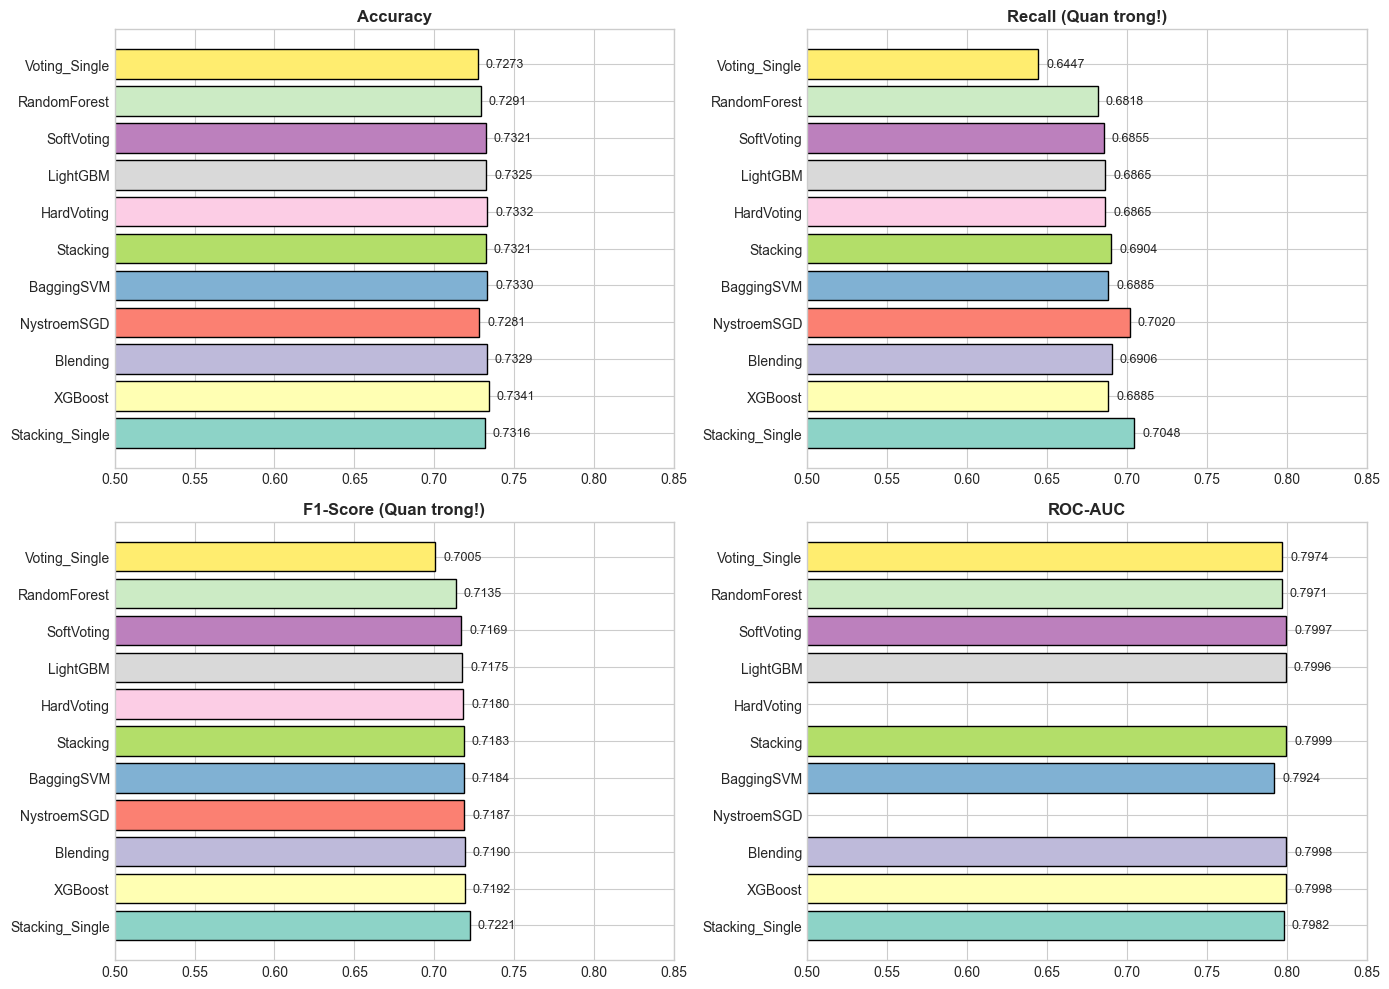

In [21]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['accuracy', 'recall', 'f1', 'roc_auc']
titles = ['Accuracy', 'Recall (Quan trong!)', 'F1-Score (Quan trong!)', 'ROC-AUC']
colors = plt.cm.Set3(np.linspace(0, 1, len(ensemble_df)))

for i, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[i // 2, i % 2]
    values = ensemble_df[metric].values
    models = ensemble_df.index
    
    valid_values = [v if v is not None else 0 for v in values]
    
    bars = ax.barh(models, valid_values, color=colors, edgecolor='black')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlim(0.5, 0.85)
    
    for bar, val in zip(bars, values):
        if val is not None:
            ax.text(val + 0.005, bar.get_y() + bar.get_height()/2, 
                    f'{val:.4f}', va='center', fontsize=9)
        else:
            ax.text(0.52, bar.get_y() + bar.get_height()/2, 
                    'N/A', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('outputs/ensemble_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Luu Models va Ket qua

In [22]:
import os
os.makedirs('models', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

# Luu cac models
for model_name, model in trained_ensembles.items():
    joblib.dump(model, f'models/ensemble_{model_name.lower()}.pkl')
    print(f"Da luu: models/ensemble_{model_name.lower()}.pkl")

# Luu best params
joblib.dump(best_params, 'models/best_params_ensemble.pkl')
print("\nDa luu best_params_ensemble.pkl")

# Luu ket qua
ensemble_df.to_csv('outputs/ensemble_models_results.csv')
print("Da luu outputs/ensemble_models_results.csv")

Da luu: models/ensemble_randomforest.pkl
Da luu: models/ensemble_xgboost.pkl
Da luu: models/ensemble_lightgbm.pkl
Da luu: models/ensemble_baggingsvm.pkl
Da luu: models/ensemble_nystroemsgd.pkl
Da luu: models/ensemble_voting_single.pkl
Da luu: models/ensemble_stacking_single.pkl
Da luu: models/ensemble_hardvoting.pkl
Da luu: models/ensemble_softvoting.pkl
Da luu: models/ensemble_stacking.pkl
Da luu: models/ensemble_blending.pkl

Da luu best_params_ensemble.pkl
Da luu outputs/ensemble_models_results.csv


## 7. Ket luan

**Cac Ensemble Models da train:**

1. **Base Ensemble:**
   - Random Forest: Bagging voi Decision Trees
   - XGBoost: Gradient Boosting
   - LightGBM: Gradient Boosting toi uu
   - Bagging SVM: 10 SVMs nho, moi cai 10% data
   - Nystroem + SGD: Kernel approximation SVM

2. **Advanced Ensemble:**
   - Hard Voting: Bo phieu da so
   - Soft Voting: Trung binh xac suat
   - Stacking: Meta-learner
   - Blending: Dung validation set

**Tiep theo:** Chuyen sang file 05 de danh gia va so sanh tat ca models.